# Project 3: Forecasting

#### All the tasks have been implemented and comments for each task has been added right below each plot 
#### Code, Results and Conclusions have been added below

In [1]:
import pandas as pd
from numpy import mean
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.ar_model import AutoReg
import numpy as np

In [2]:
series = pd.read_csv('20.csv', header=0, index_col=0)
series = series.drop(["2m Relative Humidity (percent)", "2m Station Pressure (mb)"] , axis = 1)

## Task 1

From the below plot, we notice that the series is not statonary. We this perform the difference transform to ensure that it is stationary before we can analyse the series

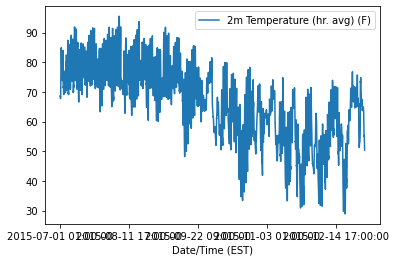

In [3]:
series.plot()

In [4]:
def difference(dataset):
    diff = list()
    for i in range(len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return diff

In [5]:
diff = difference(series["2m Temperature (hr. avg) (F)"])
def inverse_difference(x, value):
    return value + x

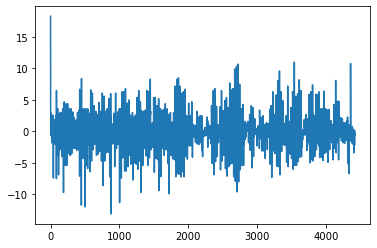

In [6]:
data = pd.Series(diff)
data.plot()

### Comments and conclusions

We notice that since the series was not stationary, we had to perform transformations on it.
From the above difference transform, we can say that we have removed seasonality and trends and the series is stationary as mentioned in 6.1.2 in the textbook.

Reference: https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/ and textbook for the course


## Task 2

Moving average smooting is to remove the fine grained variation in the data points
Splitting the data into train and test

In [7]:
training = data[:len(data)//2]
testing = data[len(data)//2:]

In [8]:
tt = series["2m Temperature (hr. avg) (F)"][:len(data)//2]

Applying moving average on the transformed series and varying the window size to determine the appropriate ideal moving window to calculate the rolling mean

In [9]:
errors = []
for k in range(2, 1000):
    rolling = training.rolling(window=k)
    rolling_mean = rolling.mean()
    error = mean_squared_error(training[:-k], rolling_mean[k:])
    error = np.sqrt(error)
    errors.append(error)

RMSE values have been listed below

In [10]:
print(errors[:25])

[1.9639469159494285, 2.029608871017312, 2.098778042523455, 2.1672710960171577, 2.2300273541375755, 2.2812882278334214, 2.3271863345670143, 2.3736639773827672, 2.422252606316692, 2.46950019621998, 2.507947049360951, 2.532072035663481, 2.540909222327925, 2.536398518449689, 2.523212537428932, 2.5041056497467005, 2.4803259944467433, 2.450063581235065, 2.413946739198944, 2.3727301035103983, 2.3234132585812515, 2.2650864430521174, 2.2053204697764306, 2.1579778661774056, 2.128628299646095]


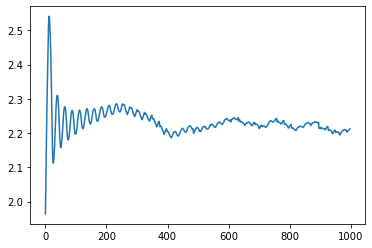

In [11]:
pd.Series(errors).plot()

From the above plot we see that when removing the obvious choice that the next day's temperature is going to be closer to current temperature, we see a window of 25 to be ideal. The above plot for 1000 such trials has been plotted.

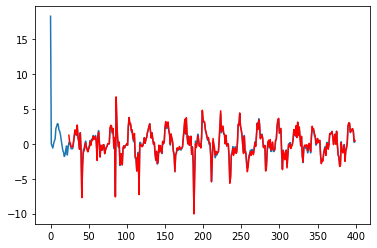

In [12]:
rolling = training.rolling(window=25)
rolling_mean = rolling.mean()
inverted = [inverse_difference(training[i], rolling_mean[i]) for i in range(len(rolling_mean))]
training[:400].plot()
pd.Series(inverted[:400]).plot(color='red')
plt.show()

## Comments and conclusions

A plot of RMSE vs k has been plotted and the ideal window size to be determined. A graph of predictions and actual training temperature has also been plotted along with the RMSE values

Reference: https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/

## Task 3

Exponential smoothing has been performed and the errors have been calculated for different smoothing levels and the lowest values have been identified.

In [13]:
errors = []
for level in range(1,10):
    model2 = SimpleExpSmoothing(training)
    fit1 = model2.fit(smoothing_level=level *0.1)
    pred1 = fit1.predict(1,len(training))
    error = mean_squared_error(training, pred1)
    error = np.sqrt(error)
    errors.append(error)

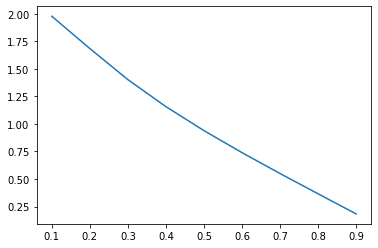

In [14]:
plt.plot([0.1*i for i in range(1,10)], errors)

Above is a plot of RMSE vs smoothing_parameter

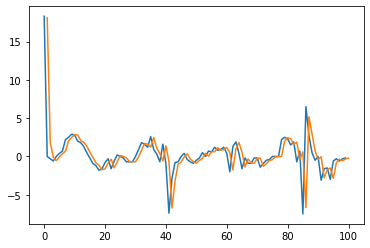

In [15]:
# pyplot.plot(fit1.fittedvalues[:100])
plt.plot(training[:100])
plt.plot(pred1[:100])

For the exponential model, the first 100 predictions have been plotted above

Ref: https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

## Task 4

The order p for AR model has been determined by plotting the PACF graph.

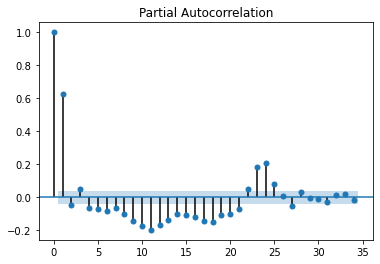

In [16]:
plot_pacf(training)
plt.show()

We notice that when p is 26, the model tends to show lesser variance. This makes us set the appropriate parameters while creating the model. Once generated, we predict the first n samples and compare the accuracy of the prediction.

In [17]:
model3 = AutoReg(training, lags=26)
model_fit3 = model3.fit()
predictions = model_fit3.predict(1, len(training), dynamic=False)

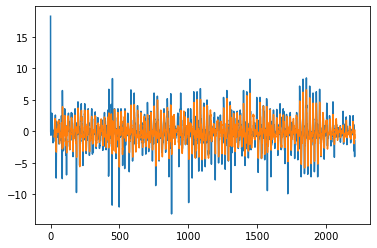

In [18]:
training.plot()
pd.Series(predictions).plot()

Above is the plot of predicted vs actual values where the predictions are in orange color.

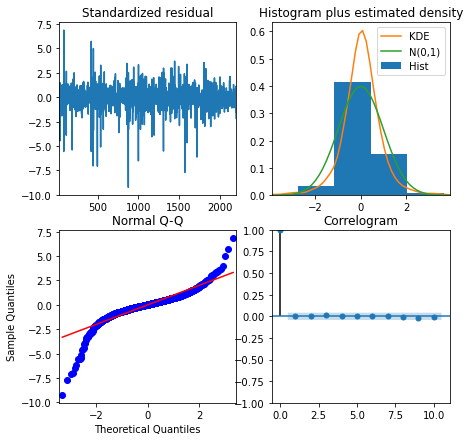

In [19]:
model_fit3.plot_diagnostics(fig=plt.figure(figsize=(7,7)))
plt.show()

This graph shows that the Q-Q plot is almost aligned with the red line making. This makes this an ideal dataset. There is little overestimation as there is only one parameter to deal with. This is one of the reasons why the Q-Q plot is almost aligned with the red line.

(array([   2.,    4.,    8.,   17.,  120., 1457.,  535.,   34.,    3.,
           2.]),
 array([-12.46721752, -10.29148231,  -8.1157471 ,  -5.94001189,
         -3.76427669,  -1.58854148,   0.58719373,   2.76292894,
          4.93866415,   7.11439935,   9.29013456]),
 <a list of 10 Patch objects>)

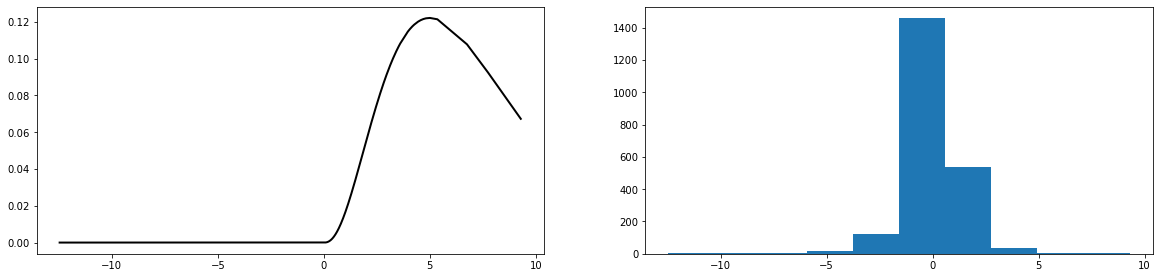

In [20]:
from scipy.stats import chi2
res = model_fit3.resid
fig = plt.figure(figsize=(20,10))
rv = chi2(7)
a, b = zip(*sorted(zip(res, rv.pdf(res))))
plt.subplot(221)
plt.plot(a, b, 'k-', lw=2, label='frozen pdf')
plt.subplot(222)
plt.hist(res)

We notice that the histogram of residuals follows a normal distribution. This makes the data pass the chi-squared test and that it follows normal distribution.

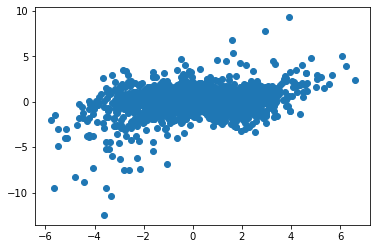

In [21]:
plt.scatter(predictions[26:], res)

Above is the scatter plot of residuals. As one can see there is an approximate distribution above and below the x axis at line y=0. Giving us the way the error has been distributed. This also shows that the randomness in the data is less

Ref: https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

## Task 5

Task 5 allows us to predict the future - the points that comes after the training sample. When plotting the points, we get the following plots along with RMSE for each of the models.

## Model 1

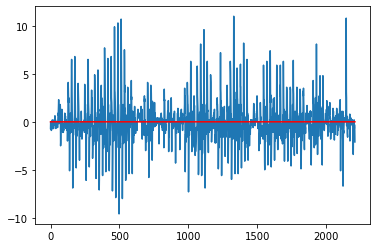

In [22]:
window=25
rolling = training.rolling(window=25)
rolling_mean = list(rolling.mean())
preds = []
for i in range(len(testing)):
    p = mean(rolling_mean[window:])
    preds.append(p)
    rolling_mean.pop(0)
    rolling_mean.append(p)
pd.Series(list(testing)).plot()
pd.Series(preds).plot(color='red')
plt.show()

MSE value for the model is prined below

In [23]:
print(np.sqrt(mean_squared_error(list(testing), preds)))

2.056782751135235


A sample value

In [24]:
print(preds[1800])

0.00519053822525196


## Model 2

In [25]:
model2 = SimpleExpSmoothing(training)
fit1 = model2.fit(smoothing_level=0.7)
pred1 = fit1.predict(len(training),len(training)+len(testing)-1)
error = mean_squared_error(list(testing), pred1)
error = np.sqrt(error)
print(error)

2.885101037559368


MSE value for the model is prined above

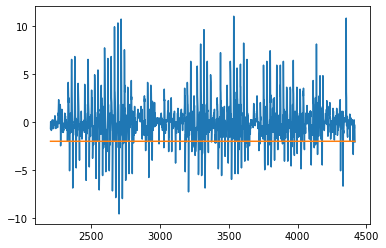

In [26]:
testing.plot()
pred1.plot()

## Model 3

In [27]:
predictions = model_fit3.predict(len(training), len(training)+len(testing)-1, dynamic=False)

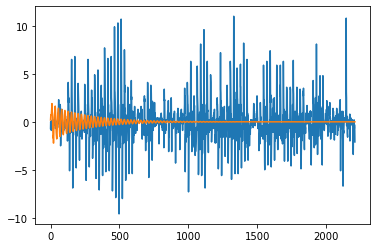

In [28]:
pd.Series(list(testing)).plot()
pd.Series(list(predictions)).plot()

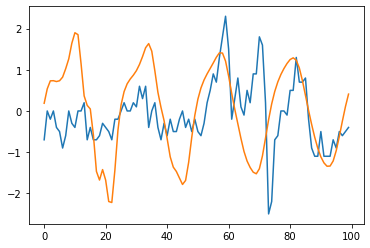

In [29]:
pd.Series(list(testing)[:100]).plot()
pd.Series(list(predictions)[:100]).plot()

MSE value for the model is prined below

In [30]:
np.sqrt(mean_squared_error(testing, predictions))

2.003074490959628

# Conclusion

The MSE valuse for each model have been listed below:

Model 1: 2.0567

Model 2: 2.8851

Model 3: 2.0030

From the three models, we notice that the AR model performed the best on the test data and we could say that this amongst the 3 would be ideal for weather prediction 



#### All references have been added below each model for reference

Other references:
    https://machinelearningmastery.com/time-series-forecast-case-study-python-monthly-armed-robberies-boston/
    https://stats.stackexchange.com/questions/371711/how-to-fit-an-autoregressive-ar1-model-with-trend-and-or-seasonality-to-a-ti
    https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/